In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report
from tqdm import tqdm
from skimage import color

import shutil
from torchvision.models import efficientnet_b0

seed = 42
random.seed(seed)

# Improvement 2 Model

Previously, our baseline model relied solely on Lab channels, but we observed that leaf images often had brown or blue backgrounds that Lab alone struggled to capture. 

To remedy this, we fused the RGB channels with Lab, creating a six‑channel input that preserves both color and luminance information. We then swapped out the randomly initialized InceptionV3 for a pretrained EfficientNet backbone, leveraging its strong ImageNet features. This dual‑color‑space approach and transfer‑learning boost significantly enhanced our model’s color extraction and overall classification performance.


By applying random resized crops, horizontal flips, small rotations, and color jitter to each image—generating roughly five distinct variants per file—we expanded the effective training set to around 3,000–4,000 unique samples, which in turn improved the model’s generalization and accuracy.

<--New--> </br>
We incorporated attention using CBAM blocks, which apply channel and spatial attention to help the model focus on the most relevant features and regions in the leaf images.


#### **What the LabTwoBranchDataset class does**:-

- Dual-Space Conversion: It processes each image in both RGB and Lab color spaces.

- RGB Transformation: It applies optional preprocessing transformations (like resizing or normalization) to the RGB image.

- Lab Conversion & Normalization:

    - Converts the RGB image to the Lab color space.

    - Normalizes the L channel to a range of [0, 1] and the AB channels to [-1, 1] for balanced input distribution.

- Lab Transformation: Allows optional transformations on the Lab image as well.

- Concatenation: Combines the processed RGB and Lab images into a single 6-channel image (3 RGB + 3 Lab).

- Label Mapping: Converts class labels into numeric format for classification tasks.


In [2]:
class RGBLABConcatDataset(Dataset):
    def __init__(self, dataframe, transform_rgb=None, transform_lab=None):
        self.data = dataframe
        self.transform_rgb = transform_rgb
        self.transform_lab = transform_lab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['filepath']
        label = torch.tensor(row['label'], dtype=torch.long)

        img = Image.open(img_path).convert("RGB")

        if self.transform_rgb:
            img_rgb = self.transform_rgb(img)
        else:
            img_rgb = transforms.ToTensor()(img)

        lab = color.rgb2lab(np.array(img)).astype('float32')
        L = lab[:, :, 0] / 100.0                      
        ab = (lab[:, :, 1:] + 128) / 255.0 * 2 - 1   

        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  

        if self.transform_lab:
            lab_img = torch.cat([L, ab], dim=0)
            lab_img = self.transform_lab(lab_img)
        else:
            lab_ig = torch.cat([L, ab], dim=0)

        fused = torch.cat([img_rgb, lab_img], dim=0)

        return fused, label, img_path

What the EfficientNetRGBLAB class does:

- Pretrained Backbone: It loads an EfficientNet‑B0 model with ImageNet‑trained weights (IMAGENET1K_V1).

- 6‑Channel Input: The very first convolution is swapped from accepting 3 channels to 6 channels, allowing it to use the fused RGB+Lab tensor.

CBAM Modules (Attention Blocks):

- A Channel and Spatial Attention block (CBAMBlock) is added after the backbone's convolutional features to help the model focus on informative channels and spatial locations.

- A second CBAM block is applied after a custom residual block to further refine features.

Residual Block: A residual path consisting of two 3×3 convolutional layers with batch normalization and ReLU is added between the two CBAM modules, enhancing deep feature learning and gradient flow.

- Custom Classification Head: It pulls out the number of features in the original classifier, replaces the final linear layer with a new one sized to num_classes, and in forward simply runs the input through the modified EfficientNet.

In [ ]:

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        return self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))


class CBAMBlock(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


class EfficientNetRGBLAB_CBAM_Deep(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

        orig = self.backbone.features[0][0]
        self.backbone.features[0][0] = nn.Conv2d(
            in_channels=6,
            out_channels=orig.out_channels,
            kernel_size=orig.kernel_size,
            stride=orig.stride,
            padding=orig.padding,
            bias=orig.bias is not None
        )

        self.cbam1 = CBAMBlock(in_planes=1280)

        self.residual_block = nn.Sequential(
            nn.Conv2d(1280, 1280, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            nn.Conv2d(1280, 1280, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1280),
        )

        self.cbam2 = CBAMBlock(in_planes=1280)

        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.cbam1(x)

        res = self.residual_block(x)
        x   = x + res  
        x = self.cbam2(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.classifier(x)
        return x


# PlantDoc Dataset

Then we trained and tested the model on the PlantDoc dataset, as was done in the paper.

[PlantDoc](https://github.com/pratikkayal/PlantDoc-Dataset)

In [4]:
# !rmdir --help
!rm -rf /kaggle/working/PlantDoc-Dataset
!git clone https://github.com/pratikkayal/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 2670, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 2670 (delta 22), reused 22 (delta 22), pack-reused 2635 (from 1)
Receiving objects: 100% (2670/2670), 932.92 MiB | 39.53 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (2581/2581), done.


### Loading the dataset

In [5]:
dataset_path = '/kaggle/working/PlantDoc-Dataset/'

def load_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    label_dict = {}  
    label_idx = 0
    class_counts = {}  
    class_samples = {}  
    
    for root, dirs, files in os.walk(dataset_path):
        if 'train' in root or 'test' in root:
            for folder in dirs:
                if folder.startswith('Tomato'):  # Only include folders starting with 'Tomato'
                    for file in os.listdir(os.path.join(root, folder)):
                        if file.endswith(('.jpg', '.png')):
                            image_path = os.path.join(root, folder, file)
                            label = folder
                            if label not in label_dict:
                                label_dict[label] = label_idx
                                label_idx += 1
                            image_paths.append(image_path)
                            labels.append(label_dict[label])
                            
                            if label not in class_counts:
                                class_counts[label] = 0
                            class_counts[label] += 1

                            if label not in class_samples:
                                class_samples[label] = []
                            if len(class_samples[label]) < 3:
                                class_samples[label].append(image_path)
    
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_dict, class_counts, class_samples

In [6]:
train_df, label_dict, train_class_counts, train_class_samples = load_image_paths_and_labels(os.path.join(dataset_path, 'train'))
test_df, _, test_class_counts, test_class_samples = load_image_paths_and_labels(os.path.join(dataset_path, 'test'))

In [7]:
print("Number of images per class in the training set:")
for label, count in train_class_counts.items():
    print(f"{label}: {count} images")

print("\nNumber of images per class in the testing set:")
for label, count in test_class_counts.items():
    print(f"{label}: {count} images")

Number of images per class in the training set:
Tomato leaf yellow virus: 70 images
Tomato leaf mosaic virus: 44 images
Tomato leaf: 55 images
Tomato mold leaf: 85 images
Tomato leaf bacterial spot: 101 images
Tomato two spotted spider mites leaf: 2 images
Tomato Septoria leaf spot: 140 images
Tomato Early blight leaf: 79 images
Tomato leaf late blight: 101 images

Number of images per class in the testing set:
Tomato leaf yellow virus: 6 images
Tomato leaf mosaic virus: 10 images
Tomato leaf: 8 images
Tomato mold leaf: 6 images
Tomato leaf bacterial spot: 9 images
Tomato Septoria leaf spot: 11 images
Tomato Early blight leaf: 9 images
Tomato leaf late blight: 10 images


### Sample Images


Sample images from class: Tomato leaf yellow virus


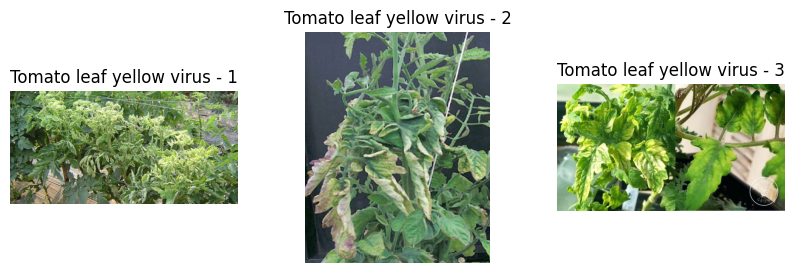


Sample images from class: Tomato leaf mosaic virus


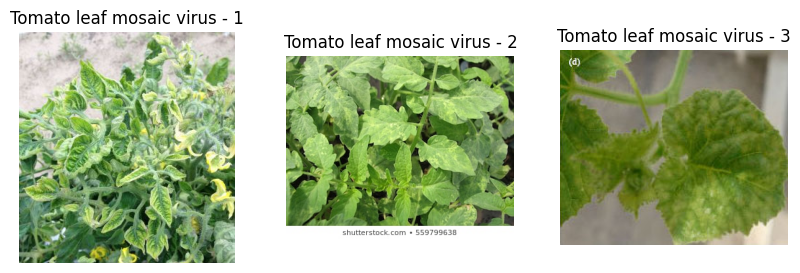


Sample images from class: Tomato leaf


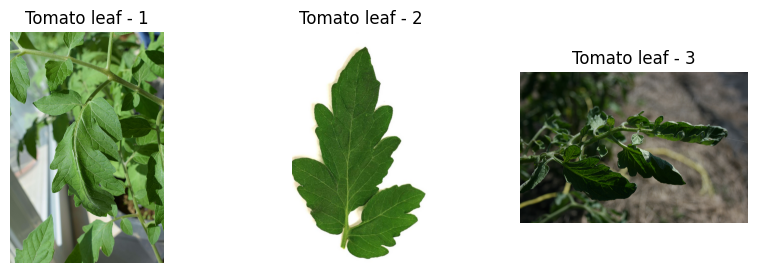


Sample images from class: Tomato mold leaf


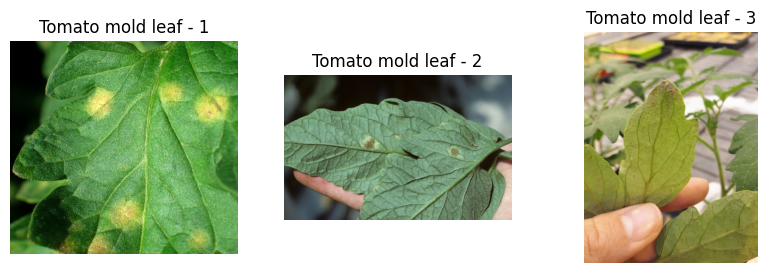


Sample images from class: Tomato leaf bacterial spot


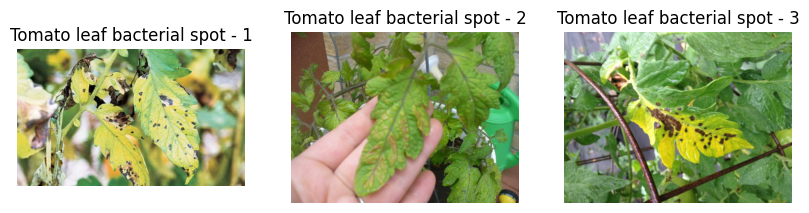


Sample images from class: Tomato two spotted spider mites leaf


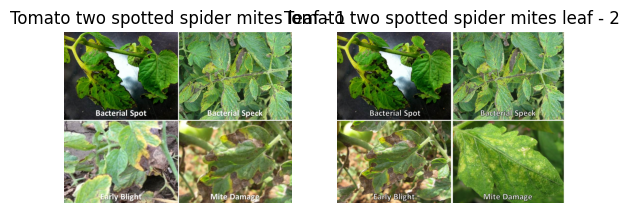


Sample images from class: Tomato Septoria leaf spot


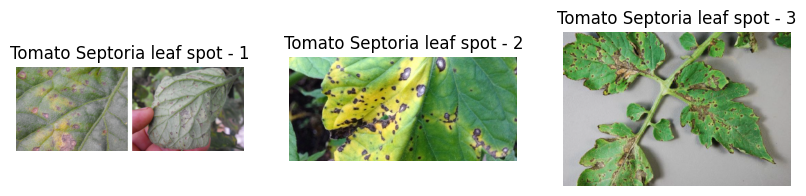


Sample images from class: Tomato Early blight leaf


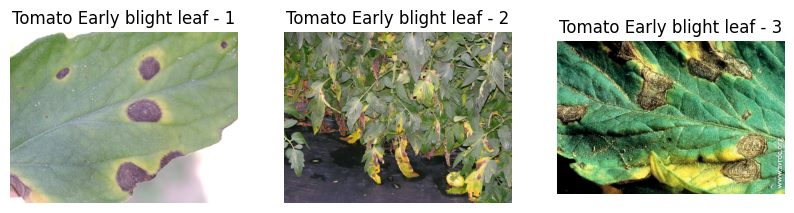


Sample images from class: Tomato leaf late blight


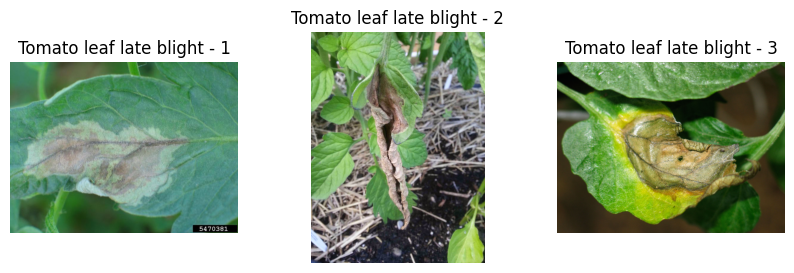


Sample images from class: Tomato leaf yellow virus


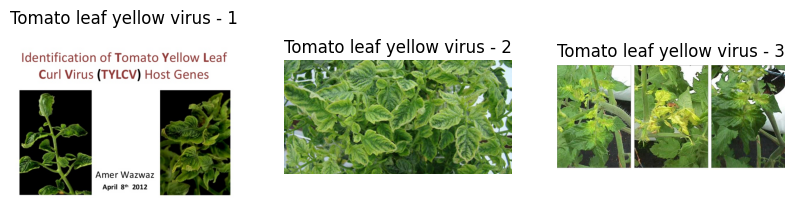


Sample images from class: Tomato leaf mosaic virus


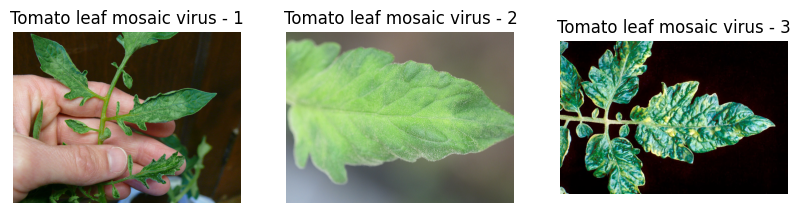


Sample images from class: Tomato leaf


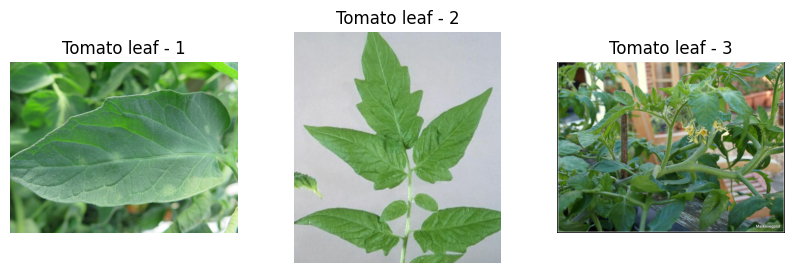


Sample images from class: Tomato mold leaf


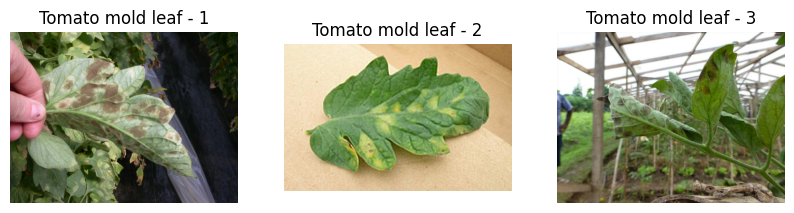


Sample images from class: Tomato leaf bacterial spot


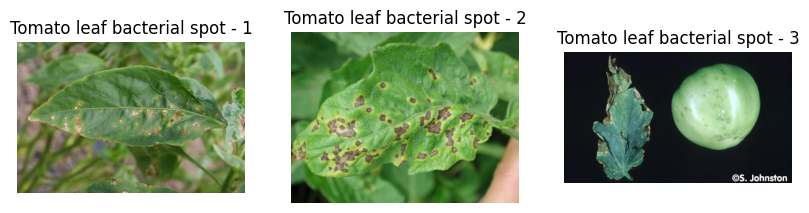


Sample images from class: Tomato Septoria leaf spot


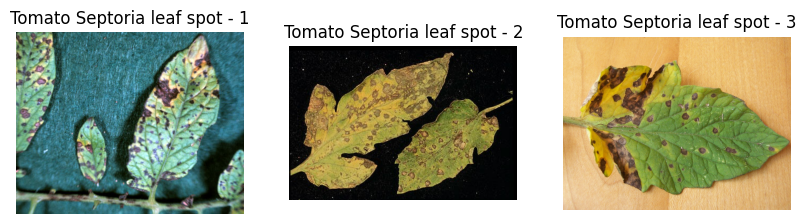


Sample images from class: Tomato Early blight leaf


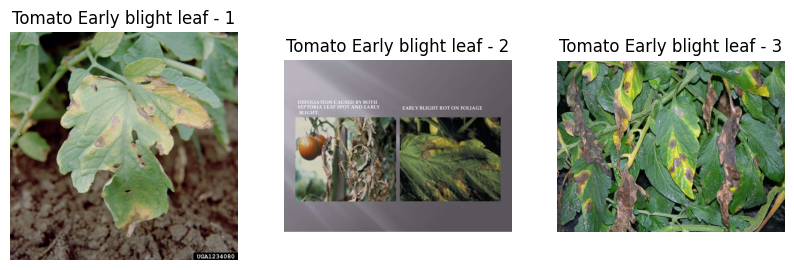


Sample images from class: Tomato leaf late blight


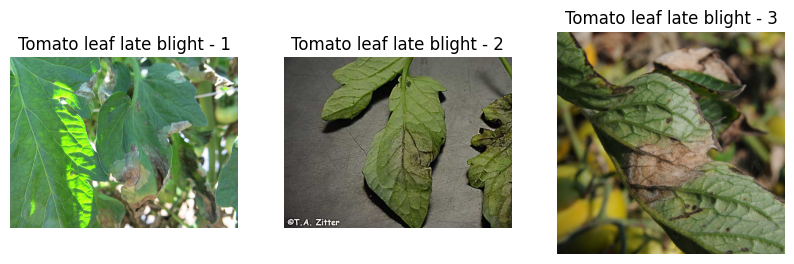

In [8]:
def show_sample_images(class_samples):
    for label, samples in class_samples.items():
        print(f"\nSample images from class: {label}")
        plt.figure(figsize=(10, 3))
        for i, img_path in enumerate(samples):
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{label} - {i+1}")
        plt.show()

show_sample_images(train_class_samples)
show_sample_images(test_class_samples)

## Train-Test Split
The original test set provided in PlantDoc was too small. So we merged both the train and test sets together, and created a new 80-20 split for our use

In [9]:
dataset_path = 'PlantDoc-Dataset/'

def merge_train_test_folders(dataset_path, exclude_class="Tomato two spotted spider mites leaf"):
    merged_dataset_path = os.path.join(dataset_path, 'merged')
    if not os.path.exists(merged_dataset_path):
        os.makedirs(merged_dataset_path)
    
    for folder in os.listdir(os.path.join(dataset_path, 'train')):
        if folder.startswith('Tomato') and folder != exclude_class:  
            class_folder = os.path.join(merged_dataset_path, folder)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
            
            train_class_folder = os.path.join(dataset_path, 'train', folder)
            for file in os.listdir(train_class_folder):
                if file.endswith(('.jpg', '.png')):
                    shutil.move(os.path.join(train_class_folder, file), os.path.join(class_folder, file))

            test_class_folder = os.path.join(dataset_path, 'test', folder)
            for file in os.listdir(test_class_folder):
                if file.endswith(('.jpg', '.png')):
                    shutil.move(os.path.join(test_class_folder, file), os.path.join(class_folder, file))
    
    print("Data merged successfully into the 'merged' folder, excluding the unwanted class.")

merge_train_test_folders(dataset_path)

Data merged successfully into the 'merged' folder, excluding the unwanted class.


In [10]:
def create_train_test_split(merged_dataset_path, exclude_class="Tomato two spotted spider mites leaf", split_ratio=0.8):
    train_image_paths = []
    train_labels = []
    test_image_paths = []
    test_labels = []
    label_dict = {}
    label_idx = 0
    
    for folder in os.listdir(merged_dataset_path):
        if folder.startswith('Tomato') and folder != exclude_class:  
            class_folder = os.path.join(merged_dataset_path, folder)
            images = [os.path.join(class_folder, file) for file in os.listdir(class_folder) if file.endswith(('.jpg', '.png'))]
            
            train_images, test_images = train_test_split(images, train_size=split_ratio, random_state=seed)

            if folder not in label_dict:
                label_dict[folder] = label_idx
                label_idx += 1
            
            for img in train_images:
                train_image_paths.append(img)
                train_labels.append(label_dict[folder])
            for img in test_images:
                test_image_paths.append(img)
                test_labels.append(label_dict[folder])
    
    train_df = pd.DataFrame({'filepath': train_image_paths, 'label': train_labels})
    test_df = pd.DataFrame({'filepath': test_image_paths, 'label': test_labels})
    return train_df, test_df, label_dict


In [16]:
merged_dataset_path = os.path.join(dataset_path, 'merged')
train_df, test_df, label_dict = create_train_test_split(merged_dataset_path)


print("Number of images per class after merge and split (Train):")
class_counts = train_df['label'].value_counts()
for label, count in class_counts.items():
    class_name = list(label_dict.keys())[list(label_dict.values()).index(label)]
    print(f"{class_name}: {count} images")

print("\n")
print("Number of images per class after merge and split (Test):")
class_counts = test_df['label'].value_counts()
for label, count in class_counts.items():
    class_name = list(label_dict.keys())[list(label_dict.values()).index(label)]
    print(f"{class_name}: {count} images")


Number of images per class after merge and split (Train):
Tomato Septoria leaf spot: 120 images
Tomato leaf bacterial spot: 88 images
Tomato leaf late blight: 88 images
Tomato mold leaf: 72 images
Tomato Early blight leaf: 70 images
Tomato leaf yellow virus: 60 images
Tomato leaf: 50 images
Tomato leaf mosaic virus: 43 images


Number of images per class after merge and split (Test):
Tomato Septoria leaf spot: 30 images
Tomato leaf late blight: 23 images
Tomato leaf bacterial spot: 22 images
Tomato mold leaf: 19 images
Tomato Early blight leaf: 18 images
Tomato leaf yellow virus: 15 images
Tomato leaf: 13 images
Tomato leaf mosaic virus: 11 images


### Model Declaration

In [ ]:

IMG_SIZE = 224

transform_rgb_aug = transforms.Compose([

    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),

    transforms.RandomAffine(
        degrees=15, 
        translate=(0.05, 0.05), 
        scale=(0.9, 1.1), 
        shear=10
    ),
    
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ], p=0.3),

    transforms.ToTensor(),

])

transform_lab = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

transform_rgb_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [18]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

train_dataset = RGBLABConcatDataset(train_df, transform_rgb=transform_rgb_aug, transform_lab=transform_lab)
test_dataset  = RGBLABConcatDataset(test_df, transform_rgb=transform_rgb_test, transform_lab=transform_lab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = EfficientNetRGBLAB_CBAM_Deep(num_classes=len(label_dict)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training Loop

In [ ]:

train_losses = []
train_accuracies = []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for fused, labels, _ in tqdm(train_loader):
        fused, labels = fused.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(fused)  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")


100%|██████████| 19/19 [01:10<00:00,  3.70s/it]


Epoch 1 - Loss: 2.0100 - Accuracy: 0.2166


100%|██████████| 19/19 [01:07<00:00,  3.58s/it]


Epoch 2 - Loss: 1.7734 - Accuracy: 0.3536


100%|██████████| 19/19 [01:06<00:00,  3.48s/it]


Epoch 3 - Loss: 1.5691 - Accuracy: 0.4264


100%|██████████| 19/19 [01:09<00:00,  3.64s/it]


Epoch 4 - Loss: 1.3976 - Accuracy: 0.4856


100%|██████████| 19/19 [01:06<00:00,  3.51s/it]


Epoch 5 - Loss: 1.1685 - Accuracy: 0.5736


100%|██████████| 19/19 [01:06<00:00,  3.51s/it]


Epoch 6 - Loss: 1.0259 - Accuracy: 0.6193


100%|██████████| 19/19 [01:09<00:00,  3.63s/it]


Epoch 7 - Loss: 0.9006 - Accuracy: 0.7107


100%|██████████| 19/19 [01:07<00:00,  3.56s/it]


Epoch 8 - Loss: 0.7326 - Accuracy: 0.7563


100%|██████████| 19/19 [01:06<00:00,  3.51s/it]


Epoch 9 - Loss: 0.7226 - Accuracy: 0.7310


100%|██████████| 19/19 [01:08<00:00,  3.59s/it]


Epoch 10 - Loss: 0.4782 - Accuracy: 0.8393


100%|██████████| 19/19 [01:08<00:00,  3.60s/it]


Epoch 11 - Loss: 0.5122 - Accuracy: 0.8511


100%|██████████| 19/19 [01:09<00:00,  3.67s/it]


Epoch 12 - Loss: 0.5534 - Accuracy: 0.8122


100%|██████████| 19/19 [01:06<00:00,  3.52s/it]


Epoch 13 - Loss: 0.4221 - Accuracy: 0.8646


100%|██████████| 19/19 [01:07<00:00,  3.56s/it]


Epoch 14 - Loss: 0.2930 - Accuracy: 0.9036


100%|██████████| 19/19 [01:05<00:00,  3.44s/it]


Epoch 15 - Loss: 0.2749 - Accuracy: 0.9154


100%|██████████| 19/19 [01:06<00:00,  3.51s/it]


Epoch 16 - Loss: 0.2933 - Accuracy: 0.9222


100%|██████████| 19/19 [01:10<00:00,  3.73s/it]


Epoch 17 - Loss: 0.3439 - Accuracy: 0.9036


100%|██████████| 19/19 [01:10<00:00,  3.69s/it]


Epoch 18 - Loss: 0.2263 - Accuracy: 0.9442


100%|██████████| 19/19 [01:10<00:00,  3.71s/it]


Epoch 19 - Loss: 0.2364 - Accuracy: 0.9239


100%|██████████| 19/19 [01:10<00:00,  3.73s/it]

Epoch 20 - Loss: 0.2292 - Accuracy: 0.9357


### Training Loss and Accuracy

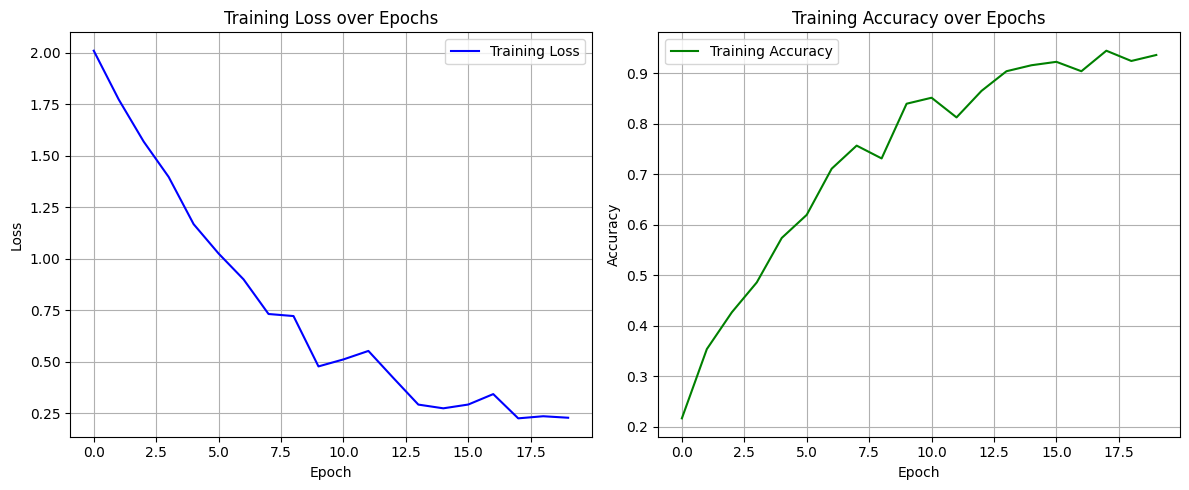

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation Results

In [21]:
model.eval()
all_preds, all_labels = [], []
misclassified = []

with torch.no_grad():
    for fused, labels, paths in tqdm(test_loader): 
        fused, labels = fused.to(device), labels.to(device)
        outputs = model(fused)
        _, preds = torch.max(outputs, 1)

        preds_np = preds.cpu().numpy()
        labels_np = labels.cpu().numpy()

        all_preds.extend(preds_np)
        all_labels.extend(labels_np)

        for i in range(len(preds_np)):
            if preds_np[i] != labels_np[i]:
                misclassified.append((paths[i], preds_np[i], labels_np[i]))


accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nAccuracy on the test set: {accuracy * 100:.2f}%")

print("\nClassification Report on Test Set:")
print(classification_report(all_labels, all_preds, target_names=list(label_dict.keys())))
print("✅ Testing complete.")


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


Accuracy on the test set: 55.63%

Classification Report on Test Set:
                            precision    recall  f1-score   support

  Tomato leaf yellow virus       0.48      0.87      0.62        15
  Tomato leaf mosaic virus       0.30      0.27      0.29        11
               Tomato leaf       0.59      1.00      0.74        13
          Tomato mold leaf       0.86      0.32      0.46        19
Tomato leaf bacterial spot       0.41      0.41      0.41        22
 Tomato Septoria leaf spot       0.50      0.53      0.52        30
  Tomato Early blight leaf       0.62      0.28      0.38        18
   Tomato leaf late blight       0.83      0.83      0.83        23

                  accuracy                           0.56       151
                 macro avg       0.57      0.56      0.53       151
              weighted avg       0.59      0.56      0.54       151

✅ Testing complete.


**Displaying misclassified images for future reference**

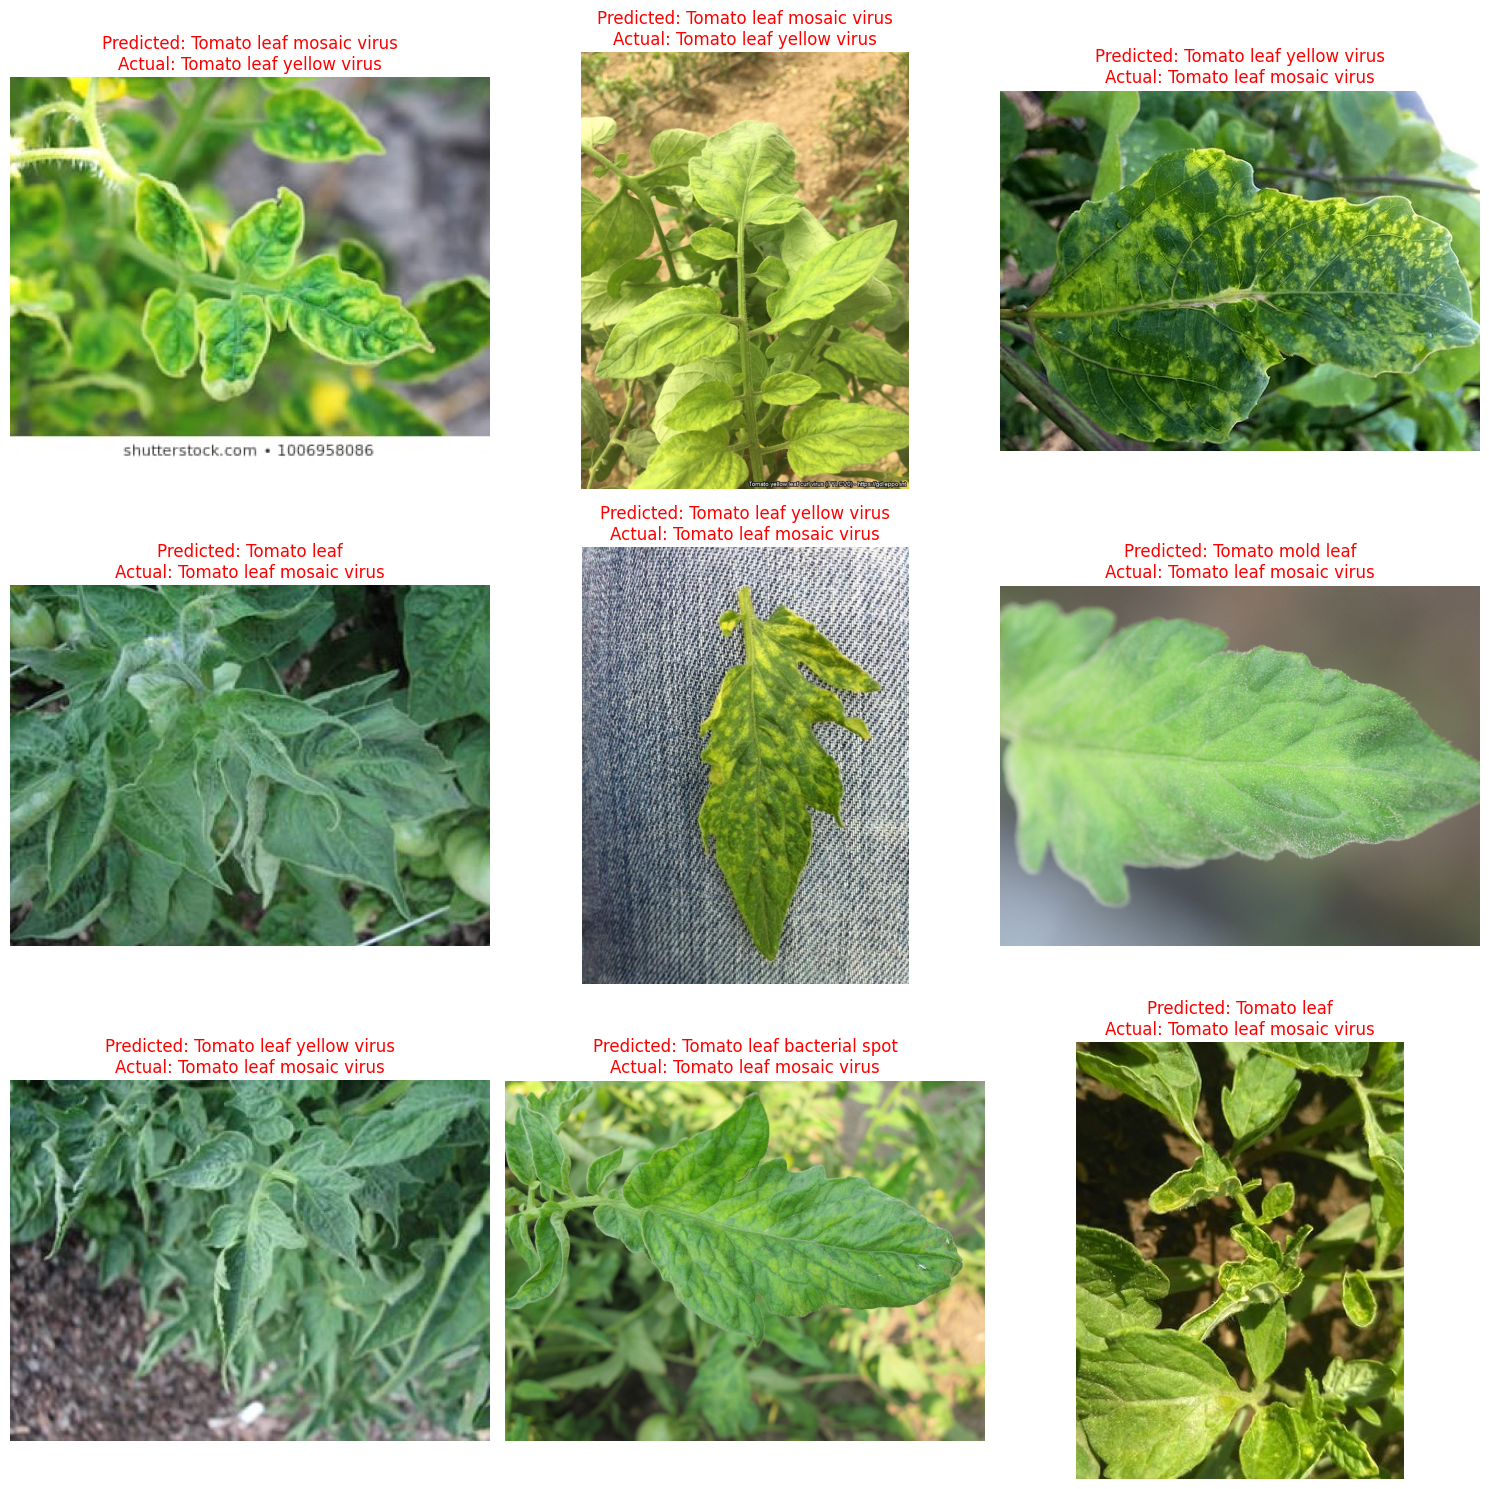

In [22]:
num_to_show = min(9, len(misclassified))
plt.figure(figsize=(15, 15))

for idx in range(num_to_show):
    path, pred_idx, true_idx = misclassified[idx]
    img = Image.open(path).convert("RGB")

    plt.subplot(int(num_to_show/3), 3, idx + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {list(label_dict.keys())[pred_idx]}\nActual: {list(label_dict.keys())[true_idx]}", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Test Accuracy: 55.63%

In [ ]:
# torch.save(model.state_dict(), "Improvement_model_RGBLAB_augmentation.pth")
# print("💾 Model saved as Baseline_model.pth")

💾 Model saved as Baseline_model.pth
